In [1]:
# standard libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# tensorflow
import tensorflow as tf
import tensorflow_decision_forests as tfdf

# scikit-learn
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set custom styles for text color
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.titlecolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'  # Color of the x-axis tick values
plt.rcParams['ytick.color'] = 'white'  # Color of the y-axis tick values

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

2023-09-22 12:29:33.536713: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [6]:
submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [7]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB


In [8]:
target = train.columns.to_list()[-1]
# convert target from bool to int
train[target] = train[target].astype(int)
train_target = train[target]

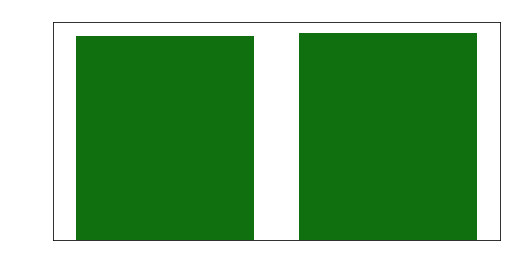

In [9]:
plt.figure(figsize=(8,4))
sns.countplot(data = train, x = target, color='g')
plt.title('Class distribution')
plt.show()

In [10]:
train.drop(target, axis=1, inplace=True)
train_id = train['PassengerId']
test_id = test['PassengerId']

In [59]:
# combine over rows, keeping id for now as group number might be useful
combined = pd.concat([train, test], axis = 0)

### Feature engineering

In [60]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
dtypes: float64(6), object(7)
memory usage: 1.4+ MB


In [61]:
combined.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [62]:
combined['Group'] = combined['PassengerId'].str[:4]
combined.drop('PassengerId', inplace=True, axis=1)

Categorical columns

In [63]:
# categorical columns
col_cat_NA = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']

# fill with Group first
for col in col_cat_NA:
    combined[col] = combined.groupby('Group')[col].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
    
# need to do this, so we can use homeplanet to fill values for destination
combined['HomePlanet'].fillna('', inplace=True)
combined['Destination'] = combined.groupby('HomePlanet')['Destination'].transform(
    lambda x: x.fillna(x.mode()[0]))
# reverse what we did earlier
combined['HomePlanet'].replace('', np.nan, inplace=True)

# now fill homeplanet with destination
combined['HomePlanet'] = combined.groupby('Destination')['HomePlanet'].transform(
    lambda x: x.fillna(x.mode()[0]))

combined['CryoSleep'] = combined.groupby('Destination')['CryoSleep'].transform(
    lambda x: x.fillna(x.mode()[0]))
combined['VIP'].fillna(False, inplace=True)
    
# need to break cabin down, this is screwing it up when the entire cabin isn't available
combined[['deck', 'cabin_num', 'side']] = combined['Cabin'].str.split('/', expand=True)

combined.drop('Cabin', inplace=True, axis=1)

col_cat_na = ['deck', 'cabin_num', 'side']

for col in col_cat_na:
    combined[col] = combined.groupby('Destination')[col].transform(
        lambda x: x.fillna(x.mode()[0]))
combined['cabin_num'] = combined['cabin_num'].astype(int)

# drop name
combined.drop('Name', inplace=True, axis=1)

Numerical columns

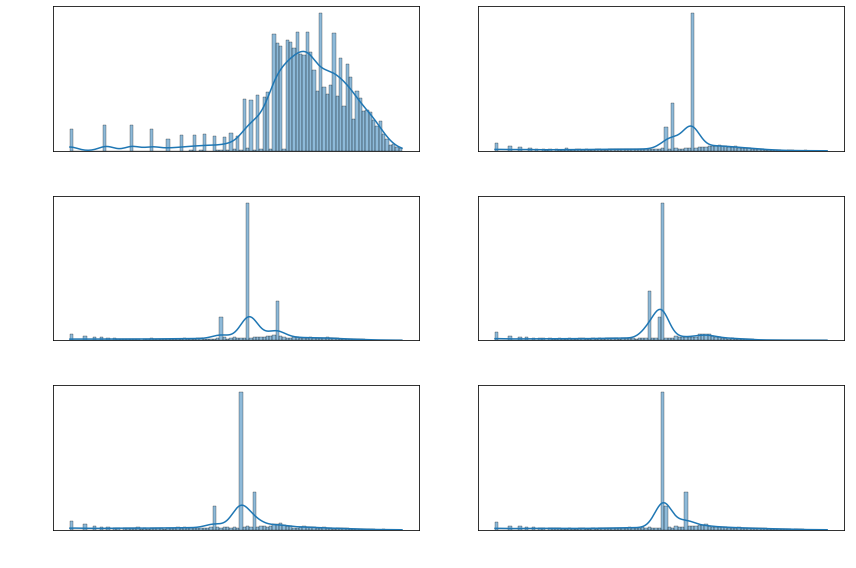

In [78]:
# numerical columns 
col_num = combined.select_dtypes(include=['number']).columns
col_num = col_num.drop(['cabin_num', 'CryoSleep'])

# subplot placehodlers
fig, axes = plt.subplots(3, 2, figsize=(12,8))

# flatten the axes for easier indexing
axes = axes.ravel()

# iterate over number columns, enumerate cause working with index list
for i, col in enumerate(col_num):
    ax = axes[i]
    # checking distribution for data above 0
    t = combined.loc[combined[col]>0]
    sns.histplot(t[col], ax=ax, kde=True, bins=100)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    
# adjust layout
plt.tight_layout()

plt.show()

In [74]:
display(combined.loc[combined['RoomService']>0].describe())
display(combined.loc[combined['RoomService']>0].median())

,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,cabin_num
count,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000
mean,0.357440,29.172501,481.638683,835.127673,355.102945,554.818463,574.333189,597.199537
std,0.479264,13.799232,706.435163,1740.654928,735.506823,1231.134891,1340.593387,511.804468
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,20.000000,193.000000,194.000000,150.000000,113.000000,231.000000,169.000000
50%,0.000000,27.000000,376.000000,357.000000,219.000000,241.000000,231.000000,418.000000
75%,1.000000,37.000000,376.000000,789.000000,219.000000,366.000000,438.000000,998.000000
max,1.000000,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1894.000000


/var/folders/3s/l2m1db5135751grhtk16_j200000gn/T/ipykernel_18127/3600371989.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  display(combined.loc[combined['RoomService']>0].median())


CryoSleep          0.0
Age               27.0
VIP                0.0
RoomService      376.0
FoodCourt        357.0
ShoppingMall     219.0
Spa              241.0
VRDeck           231.0
Group           4632.0
cabin_num        418.0
dtype: float64

In [71]:
# replace 0s with null
combined[col_num] = combined[col_num].replace(0, np.nan)

# fill with Group first
for i, col in enumerate(col_num):
    combined[col] = combined.groupby('Group')[col].transform(
        lambda x: x.fillna(x.mean()))

In [73]:
# fill with destination now
for i, col in enumerate(col_num):
    combined[col] = combined.groupby('Destination')[col].transform(
        lambda x: x.fillna(x.median()))

In [77]:
# take log due to skewed distribution
for i, col in enumerate(col_num):
    combined[col] = np.log1p(combined[col])

In [79]:
# adding new features
combined['TotalSpent'] = combined[['RoomService', 'FoodCourt', 
                                   'ShoppingMall','Spa', 'VRDeck']].sum(axis=1)

# since the distribution is so skewed to 0s, this might help
combined['moneySpent'] = (combined['TotalSpent']>0).astype(int)

In [80]:
combined['VIP'].unique()

array([0.0, 1.0], dtype=object)

<Figure size 864x576 with 0 Axes>

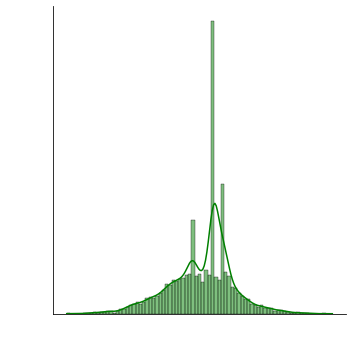

In [81]:
col = 'TotalSpent'
plt.figure(figsize=(12,8))
sns.displot(data=combined, x=col, color='g', kde=True)
plt.show()

In [82]:
col_bool = ['CryoSleep', 'VIP']

# correct dtypes of boolean columns from object to bool then to int
for col in col_bool:
    combined[col] = combined[col].astype(bool).astype(int)

In [83]:
# convert category columns to numerical/binary
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12970 non-null  object 
 1   CryoSleep     12970 non-null  int64  
 2   Destination   12970 non-null  object 
 3   Age           12970 non-null  float64
 4   VIP           12970 non-null  int64  
 5   RoomService   12970 non-null  float64
 6   FoodCourt     12970 non-null  float64
 7   ShoppingMall  12970 non-null  float64
 8   Spa           12970 non-null  float64
 9   VRDeck        12970 non-null  float64
 10  Group         12970 non-null  object 
 11  deck          12970 non-null  object 
 12  cabin_num     12970 non-null  int64  
 13  side          12970 non-null  object 
 14  TotalSpent    12970 non-null  float64
 15  moneySpent    12970 non-null  int64  
dtypes: float64(7), int64(4), object(5)
memory usage: 1.7+ MB


In [84]:
# one hot encoding
combined = pd.get_dummies(combined, columns=['HomePlanet', 'Destination', 'deck', 'side'])

# shouldn't be, but for now, let's...maybe this does make sense after all
combined['Group'] = combined['Group'].astype('int')

In [85]:
# change dtypes to int
combined.iloc[:, -16:] = combined.iloc[:, -16:].astype(int)

In [86]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  12970 non-null  int64  
 1   Age                        12970 non-null  float64
 2   VIP                        12970 non-null  int64  
 3   RoomService                12970 non-null  float64
 4   FoodCourt                  12970 non-null  float64
 5   ShoppingMall               12970 non-null  float64
 6   Spa                        12970 non-null  float64
 7   VRDeck                     12970 non-null  float64
 8   Group                      12970 non-null  int64  
 9   cabin_num                  12970 non-null  int64  
 10  TotalSpent                 12970 non-null  float64
 11  moneySpent                 12970 non-null  int64  
 12  HomePlanet_Earth           12970 non-null  int64  
 13  HomePlanet_Europa          12970 non-null  int6

### Model design

In [87]:
train = combined.iloc[:train_id.shape[0]]
test = combined.iloc[-test_id.shape[0]:]
train[target] = train_target
print('Train shape', train.shape)
print('Test shape', test.shape)

Train shape (8693, 29)
Test shape (4277, 28)


/var/folders/3s/l2m1db5135751grhtk16_j200000gn/T/ipykernel_18127/2658725243.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[target] = train_target


In [88]:
# let's split train data into train/test
def train_test_split(data, test_ratio=0.3):
    test_indices = np.random.rand(data.shape[0]) < test_ratio
    return data[~test_indices], data[test_indices]
train_data, test_data = train_test_split(train)
print('{} samples in training, {} samples in testing data'.format(train_data.shape[0], 
                                                            test_data.shape[0]))

6099 samples in training, 2594 samples in testing data


In [89]:
train_data

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,cabin_num,...,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,side_P,side_S,Transported
1,0,3.218876,0,4.700480,2.302585,3.258097,6.309918,3.806662,2,0,...,0,0,0,0,1,0,0,0,1,1
2,0,4.077537,1,3.784190,8.182280,5.918894,8.812248,3.912023,3,0,...,0,0,0,0,0,0,0,0,1,0
3,0,3.526361,0,3.784190,7.157735,5.918894,8.110728,5.267858,3,0,...,0,0,0,0,0,0,0,0,1,0
5,0,3.806662,0,5.267858,6.182085,5.290789,5.676754,5.517453,5,0,...,0,0,0,0,1,0,0,1,0,1
6,0,3.295837,0,3.761200,7.339538,1.386294,5.488938,5.446737,6,2,...,0,0,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8687,0,3.433987,0,0.693147,8.073715,5.393628,1.098612,5.802118,9275,97,...,0,0,0,0,0,0,0,1,0,1
8688,0,3.737670,1,5.446737,8.827615,5.017280,7.404888,4.317488,9276,98,...,0,0,0,0,0,0,0,1,0,0
8689,1,2.944439,0,5.267858,5.043425,5.290789,4.736198,5.517453,9278,1499,...,0,0,0,0,0,1,0,0,1,0
8690,0,3.295837,0,5.932245,5.880533,7.535297,0.693147,5.446737,9279,1500,...,0,0,0,0,0,1,0,0,1,1


In [90]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6099 entries, 1 to 8692
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  6099 non-null   int64  
 1   Age                        6099 non-null   float64
 2   VIP                        6099 non-null   int64  
 3   RoomService                6099 non-null   float64
 4   FoodCourt                  6099 non-null   float64
 5   ShoppingMall               6099 non-null   float64
 6   Spa                        6099 non-null   float64
 7   VRDeck                     6099 non-null   float64
 8   Group                      6099 non-null   int64  
 9   cabin_num                  6099 non-null   int64  
 10  TotalSpent                 6099 non-null   float64
 11  moneySpent                 6099 non-null   int64  
 12  HomePlanet_Earth           6099 non-null   int64  
 13  HomePlanet_Europa          6099 non-null   int64

Model: Logistic Regression

In [ ]:
lr = LogisticRegression(max_iter=10000)
lr.fit(train_data.iloc[:, :-1], train_data[target])

In [ ]:
prediction = lr.predict(test_data.iloc[:, :-1])

In [ ]:
accuracy = accuracy_score(test_data[target], prediction)
print('Accuracy of {}'.format(accuracy))

Model: SVM (takes a while to run this though)

In [ ]:
# param_grid = {
#     'C': [0.1, 1, 10], # regularization parameter
#     'kernel': ['linear', 'rbf'], # kernel type
#     'gamma': [0.1, 1, 10] # kernel coefficient
# }

# svm = SVC()
# grid_search = GridSearchCV(svm, param_grid, cv=5)
# grid_search.fit(train_data.iloc[:, :-1], train_data[target])

# grid_search.best_params_

Model: TFDF

In [91]:
# convert these to tensorflow datasets
train_data = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label=target)
test_data = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label=target)

In [92]:
rf = tfdf.keras.RandomForestModel()
rf.fit(train_data)

Use /var/folders/3s/l2m1db5135751grhtk16_j200000gn/T/tmpj048b823 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:03.634641. Found 6099 examples.
Training model...


[INFO 23-09-22 13:42:29.8094 MDT kernel.cc:1243] Loading model from path /var/folders/3s/l2m1db5135751grhtk16_j200000gn/T/tmpj048b823/model/ with prefix 958764efcaa744c3


Model trained in 0:00:01.333759
Compiling model...


[INFO 23-09-22 13:42:30.2797 MDT decision_forest.cc:660] Model loaded with 300 root(s), 251552 node(s), and 26 input feature(s).
[INFO 23-09-22 13:42:30.2798 MDT abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-09-22 13:42:30.2798 MDT kernel.cc:1075] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [93]:
rf.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (28):
	Age
	CryoSleep
	Destination_55_Cancri_e
	Destination_PSO_J318.5-22
	Destination_TRAPPIST-1e
	FoodCourt
	Group
	HomePlanet_Earth
	HomePlanet_Europa
	HomePlanet_Mars
	RoomService
	ShoppingMall
	Spa
	TotalSpent
	VIP
	VRDeck
	cabin_num
	deck_A
	deck_B
	deck_C
	deck_D
	deck_E
	deck_F
	deck_G
	deck_T
	moneySpent
	side_P
	side_S

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.                 "CryoSleep"  0.257499 ################
    2.               "RoomService"  0.158450 ######
    3.                 "FoodCourt"  0.153273 ######
    4.                       "Spa"  0.145297 #####

In [94]:
rf.compile(metrics=['accuracy'])
evaluation = rf.evaluate(test_data, return_dict=True)
display(evaluation)

3/3 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 0.7995


{'loss': 0.0, 'accuracy': 0.7995374202728271}

In [95]:
# tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

Prediction

In [96]:
test = tfdf.keras.pd_dataframe_to_tf_dataset(test)
predictions = rf.predict(test)
output = pd.DataFrame({'PassengerId': test_id, 'Transported': predictions.squeeze()})
# convert to boolean
output[target] = (output[target] >= 0.5)

5/5 [==============================] - 0s 27ms/step


In [97]:
output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB


In [98]:
output.to_csv('data/sample_submission.csv', index=False)